In [99]:
from linares_plot import *
import os
import datetime
from datetime import datetime as dt
import re


In [114]:
##Actions Gea data
df_gea=pd.read_excel(os.getcwd() + '\\EVENTOS_GEA.xlsx', sheet_name='Hoja2' )
times_s = [df_gea.tiempo.iloc[i].minute*60 + df_gea.tiempo.iloc[i].second for i in range(len(df_gea))]
df_gea['times_s'] = times_s

### cambiar tiempo y tiempo_s por los corregidos, en los que se restan 10 minutos, 31 segundos. De esta manera, 
### los dos dataframes están sincronizados

new_times=[]
times_s_new=[]

for i in range(len(df_gea)):
    #print(i)
    h = df_gea.tiempo.iloc[i]
    h_t = str(h.hour) + ':' + str(h.minute) + ':' + str(h.second) 
    substracting = '00:10:31'
    new_time = dt.strptime(h_t, "%H:%M:%S") - dt.strptime(substracting, "%H:%M:%S")
    new_times.append(new_time)
    ##
    times_s_new.append(df_gea.times_s.loc[i] - (60*10 + 31) ) 

    
df_gea['tiempo'] = new_times 
df_gea['times_s'] = times_s_new 

df_gea = df_gea.sort_values(by=['times_s'])

df_gea= df_gea.reset_index()
df_gea = df_gea[['tiempo', 'evento', 'decripcion', 'times_s']]
df_gea['evento_'] = df_gea['evento'].copy()
df_gea['evento_'] = df_gea['evento_'].replace(['Miniclimax', 'Climax final' ], ['climax', 'climax']) #for simplicity
df_gea.head()

,tiempo,evento,decripcion,times_s,evento_
0,00:00:27,gag,broma sobre su dominio del catalán,27,gag
1,00:00:34,gag,"""Por deferencia""",34,gag
2,00:00:46,inicio,Abre el estuche de la baraja,46,inicio
3,00:01:05,gag,"""Que haya público""",65,gag
4,00:01:19,gag,"""El público de schroedinger""",79,gag


In [158]:
##Memory data
df_ = pd.read_excel('C:\\Users\\David\\Documents\\GitHub\\Gea_memory\\df_proces.xlsx') 

df_int = df_.loc[(df_['session']==1) & ((df_['juego']==1) | (df_['juego']==2) | (df_['juego']==3)  | 
                               (df_['juego']==4)  | (df_['juego']==5)  | (df_['juego']==6)  | 
                               (df_['juego']==7) | (df_['juego']==8)), 
        ['recuerdo', 'juego', 'asiento', 'subj', 'tiempo', 'n_saliencias', 'edad', 'sexo']]

df_int = df_int.reset_index(drop=True) 
df_int['subj']=df_int['subj']+1
df_int.head()

,recuerdo,juego,asiento,subj,tiempo,n_saliencias,edad,sexo
0,0,1,38,1,1,0,24,m
1,0,2,38,1,1,0,24,m
2,0,3,38,1,1,0,24,m
3,1,4,38,1,1,1,24,m
4,1,5,38,1,1,3,24,m


In [140]:
## seleccionar truco
T='Truco 1'

df=pd.read_excel(os.getcwd() + '\\ANOTACIONES2.xlsx', sheet_name= T )

In [139]:
df.head()

,tiempo,1a,1b,2a,2b,3a,3b,4a,4b,5a,...,33a,33b,34a,34b,35a,35b,36a,37a,38a,38b
0,00:06:24,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,...,NaN,NaN,a3,NaN,a4,NaN,NaN,NaN,NaN,NaN
1,00:06:26,NaN,NaN,B,NaN,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
2,00:06:28,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,...,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00:06:30,NaN,NaN,S,NaN,P,NaN,NaN,NaN,NaN,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00:06:32,S,NaN,R,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
list_columns_subjects = list(df.columns)
list_columns_subjects.remove('tiempo')
trick_ = 1
##list_columns_subjects=list_columns_subjects[70:84] ## para ir comprobando, una a una, que no haya espacios vacíos!

frames=[]

for subject in list_columns_subjects:
    #print(subject)
    dfs = df[['tiempo', subject]]
    dfs = dfs.loc[~pd.isna(dfs[subject])] # Quitar todos los NaN (qudarnos solo con los eventos)
    ####################################### Añadir una columna de segundos
    times_s=[]
    for i in range(0, len(dfs)):
        l = dfs.tiempo.iloc[i]
        times_s.append(  int(datetime.timedelta(hours=l.hour, minutes=l.minute, seconds=l.second).total_seconds()) )
    #
    dfs.columns=['tiempo', 'event']
    dfs['time_s'] = times_s
    ####################################### Añadir columna de subject y de truco
    dfs['trick'] = int(T.split(' ')[-1]) ## last character of the string is the number of the trick
    dfs['subject'] = int(re.findall('\d+', subject)[0]) ##separate leter from number
    frames.append(dfs)
    
    
dfs=pd.concat(frames)

In [239]:
df_subjects=[]

for subject in dfs.subject.unique():
    ####################################################### get the subject and sort by time, add duration and reset index
    df_x = dfs.loc[dfs['subject']==subject]
    df_x = df_x.sort_values(by=['time_s'])
    df_x['duration']=1
    df_x = df_x.reset_index(drop=True) 
    ###################################################### get actions with * --> calculate durations of previous and eliminate * actions
    boole=[] ###bolean to get the final of actions
    for i in range(len(df_x)):
        stri = df_x['event'].iloc[i]
        boole.append( stri[-1]=='*' )
    #
    boole=np.array(boole)
    finals = df_x[boole]
    for fi in range(len(finals)):
        event_final = finals.event.iloc[fi][:-1] ##without the astherisc
        time_final = finals.time_s.iloc[fi]
        #
        previous_event = df_x.loc[(df_x['event']==event_final) & (df_x['time_s']<time_final) ].iloc[-1] ##get the last one
        duration_event = time_final - previous_event.time_s
        ## Change the duration of the dataframe
        df_x.at[previous_event.name, 'duration'] = duration_event
    #
    df_x = df_x[~boole] ### remove the events with astherist
    ######################################################  gat applauses --> add duration (break A)
    boole_apl=[] ###bolean to get the final of actions
    for i in range(len(df_x)):
        stri = df_x['event'].iloc[i]
        if stri[0]=='a':
            boole_apl.append(True)
        elif stri[0]=='A':
            boole_apl.append(True)
        else:
            boole_apl.append(False)
    #
    boole_apl=np.array(boole_apl)    
    aplauses = df_x[boole_apl]
    for ap in range(len(aplauses)):
        event_ = aplauses.iloc[ap] 
        name_event = event_.event
        duration_app = int(re.findall('\d+', name_event)[0])
        evnt = re.split('(\d+)', name_event)[0]
        #
        df_x.at[event_.name, 'duration'] = duration_app
        df_x.at[event_.name, 'event'] = evnt
    #
    ###################################################### get previous action of the magician and Reaction time respect it
    prev_event=[]
    times_after=[]
    for evnt in range(len(df_x)):
        time_ = df_x.iloc[evnt].time_s    
        previous_events_gea = df_gea.loc[df_gea['times_s']<=time_]
        if len(previous_events_gea)==0:
            prev_event.append('None')
            times_after.append(-1)
        else:
            previous_event=previous_events_gea.evento.iloc[-1]
            prev_event.append(previous_event)
            time_after = df_x.time_s.iloc[evnt] - previous_events_gea.times_s.iloc[-1]
            times_after.append(time_after)
    ##
    df_x['RT'] = times_after
    df_x['previous_event'] = prev_event
    ###################################################### get future action of the magician and anticiipation time respect it
    next_event=[]
    times_before=[]
    for evnt in range(len(df_x)): 
        time_ = df_x.iloc[evnt].time_s    
        posts_events_gea = df_gea.loc[df_gea['times_s']>time_]
        if len(previous_events_gea)==0:
            next_event.append('None')
            times_before.append(1)
        else:
            next_evnt=posts_events_gea.evento.iloc[0]
            next_event.append(next_evnt)
            time_before = df_x.time_s.iloc[evnt] - posts_events_gea.times_s.iloc[0]
            times_before.append(time_before)
    ##
    df_x['anticip_time'] = times_before
    df_x['next_event'] = next_event
    ###################################################### add memory data
    if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==1)]):
        r1 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==1)].recuerdo.iloc[0]
    else:
        r1='Miss'

    if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==2)]):
        r2 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==2)].recuerdo.iloc[0]
    else:
        r2='Miss'

    if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==3)]):
        r3 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==3)].recuerdo.iloc[0]
    else:
        r3='Miss'

    if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==4)]):
        r4 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==trick_) & (df_int['tiempo']==4)].recuerdo.iloc[0]
    else:
        r4='Miss'

    df_x['r1'] = r1
    df_x['r2'] = r2
    df_x['r3'] = r3
    df_x['r4'] = r4
    ######################################################

    df_subjects.append(df_x)
    

    
    

In [240]:
df_subjects=pd.concat(df_subjects)

In [241]:
df_subjects

,tiempo,event,time_s,trick,subject,duration,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,00:00:06,Se,6,1,1,1,-1,None,-21,gag,0,0,0,0
1,00:00:10,Si,10,1,1,1,-1,None,-17,gag,0,0,0,0
2,00:00:12,N,12,1,1,102,-1,None,-15,gag,0,0,0,0
3,00:00:32,In,32,1,1,1,5,gag,-2,gag,0,0,0,0
4,00:01:02,In,62,1,1,1,16,inicio,-3,gag,0,0,0,0
5,00:01:32,In,92,1,1,1,1,gag,-27,gag,0,0,0,0
6,00:01:48,L,108,1,1,1,17,gag,-11,gag,0,0,0,0
8,00:01:54,L,114,1,1,1,23,gag,-5,gag,0,0,0,0
9,00:02:02,N,122,1,1,2,3,gag,-20,gag,0,0,0,0
11,00:02:08,N,128,1,1,20,9,gag,-14,gag,0,0,0,0


In [242]:
df_subjects.event.unique()

array(['Se', 'Si ', 'N', 'In', 'L', 'I', 'S', 'a', 'F', 'C', 'A', 'R',
       'P', 'D', 'Si', 'M', '  C', 'AA', 'O', 'O ', 'A+', 'AA+', 'B',
       'a+', 'In ', 'PV', 'L ', 'C ', 'I   ', 'O  ', 'In   '],
      dtype=object)

In [243]:
df_subjects['event'] = df_subjects['event'].replace(['L '], ['L'])
df_subjects['event'] = df_subjects['event'].replace(['Si '], ['Si'])
df_subjects['event'] = df_subjects['event'].replace(['O '], ['O'])
df_subjects['event'] = df_subjects['event'].replace(['O  '], ['O'])
df_subjects['event'] = df_subjects['event'].replace(['In '], ['In'])
df_subjects['event'] = df_subjects['event'].replace(['In  '], ['In'])
df_subjects['event'] = df_subjects['event'].replace(['In   '], ['In'])
df_subjects['event'] = df_subjects['event'].replace(['I  '], ['I'])
df_subjects['event'] = df_subjects['event'].replace(['I   '], ['I'])
df_subjects['event'] = df_subjects['event'].replace(['C '], ['C'])
df_subjects['event'] = df_subjects['event'].replace(['  C'], ['C'])

In [244]:
df_subjects.event.unique()

array(['Se', 'Si', 'N', 'In', 'L', 'I', 'S', 'a', 'F', 'C', 'A', 'R', 'P',
       'D', 'M', 'AA', 'O', 'A+', 'AA+', 'B', 'a+', 'PV'], dtype=object)

In [245]:
df_subjects.head()

,tiempo,event,time_s,trick,subject,duration,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,00:00:06,Se,6,1,1,1,-1,None,-21,gag,0,0,0,0
1,00:00:10,Si,10,1,1,1,-1,None,-17,gag,0,0,0,0
2,00:00:12,N,12,1,1,102,-1,None,-15,gag,0,0,0,0
3,00:00:32,In,32,1,1,1,5,gag,-2,gag,0,0,0,0
4,00:01:02,In,62,1,1,1,16,inicio,-3,gag,0,0,0,0


In [248]:
df_appl = df_subjects.loc[(df_subjects['trick']==trick) & ( (df_subjects['event']=='A') | (df_subjects['event']=='AA') 
                                                       | (df_subjects['event']=='a') | (df_subjects['event']=='A+'))  ]
df_appl = df_appl[['time_s', 'duration']]
df_appl = df_appl.sort_values('time_s')
df_appl['val']=1

xs = np.arange(df_appl.time_s.min(), df_appl.time_s.max()+2,2)
missing_times=[]
for t in xs:
    if t not in t_A.time_s.unique():
        missing_times.append([t, 0, 0])
        
df_miss = pd.DataFrame(missing_times)
df_miss.columns=df_appl.columns
df_appl = pd.concat([df_appl, df_miss])
df_appl['general_label'] ='applause'

df_appl

,time_s,duration,val,general_label
0,2,6,1,applause
0,2,6,1,applause
1,2,5,1,applause
0,2,5,1,applause
0,2,6,1,applause
1,2,5,1,applause
1,2,3,1,applause
0,2,5,1,applause
0,2,5,1,applause
0,2,5,1,applause


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


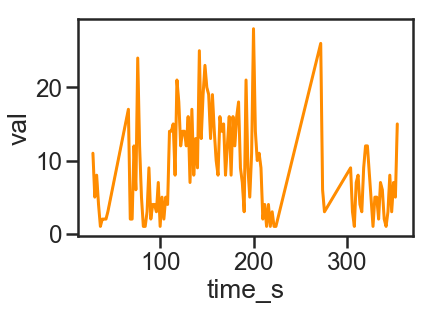

In [237]:
sns.lineplot(x='time_s', y='val', data=df_subjects.loc[df_subjects['previous_event']=='gag'], color='darkorange', estimator=np.sum, linewidth=3)


In [232]:
t_A

,tiempo,event,time_s,trick,subject,duration,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4,val
0,00:00:02,A,2,1,7,6,-1,None,-25,gag,0,0,0,Miss,1
0,00:00:02,A,2,1,23,6,-1,None,-25,gag,1,1,Miss,0,1
1,00:00:02,A,2,1,13,5,-1,None,-25,gag,1,1,Miss,Miss,1
0,00:00:02,A,2,1,31,5,-1,None,-25,gag,0,0,0,0,1
0,00:00:02,A,2,1,30,6,-1,None,-25,gag,0,0,0,0,1
1,00:00:02,A,2,1,8,5,-1,None,-25,gag,0,0,0,0,1
1,00:00:02,a,2,1,15,3,-1,None,-25,gag,0,0,0,0,1
0,00:00:02,A,2,1,24,5,-1,None,-25,gag,1,Miss,Miss,Miss,1
0,00:00:02,A+,2,1,16,5,-1,None,-25,gag,0,0,0,0,1
0,00:00:02,A,2,1,9,5,-1,None,-25,gag,1,1,Miss,Miss,1


In [ ]:
sns.lineplot(x='time_s', y='val', data=Tx.loc[Tx['general_label']=='humor'], color='darkorange', estimator=np.sum, linewidth=3)


In [230]:
trick=1

t_A = df_subjects.loc[(df_subjects['trick']==trick) & ( (df_subjects['event']=='A') | (df_subjects['event']=='AA') 
                                                       | (df_subjects['event']=='a') | (df_subjects['event']=='A+'))  ]
t_A =t_A.sort_values('time_s')
t_A['val']=1

xs = np.arange(t_A.time_s.min(), t_A.time_s.max()+2,2)
nothing=[]
for t in xs:
    if t not in t_A.time_s.unique():
        ##nothing.append([t, t, 'app', 'no', 1, 'nothing', 0])
        
df_nothing = pd.DataFrame(nothing)
df_nothing.columns=t_A.columns
t_A = pd.concat([t_A, df_nothing])
t_A['general_label'] ='applause'

####

t_H = df_subjects.loc[(df_subjects['trick']==trick) & ( (df_subjects['event']=='S') |  (df_subjects['event']=='R') ) ]
t_H =t_H.sort_values('time_s')
t_H['val']=1

xs = np.arange(t_H.time_s.min(), t_H.time_s.max()+2,2)
nothing=[]
for t in xs:
    if t not in t_H.time_s.unique():
        nothing.append([t, t, 'hum', 'no', 1, 'nothing', 0])
        
df_nothing = pd.DataFrame(nothing)
df_nothing.columns=t_H.columns
t_H = pd.concat([t_H, df_nothing])
t_H['general_label'] ='humor'


##
Tx = pd.concat([t_A, t_H])


plt.figure(figsize=(15,4))   

sns.lineplot(x='time_s', y='val', data=Tx.loc[Tx['general_label']=='humor'], color='darkorange', estimator=np.sum, linewidth=3)
sns.lineplot(x='time_s', y='val', data=Tx.loc[Tx['general_label']=='applause'], color='darkblue', estimator=np.sum, linewidth=3)

tim_mi = Tx.time_s.min()  
tim_mx = Tx.time_s.max()  

events_trick = df_gea.loc[(df_gea['times_s']>tim_mi) & (df_gea['times_s']<tim_mx)]

for i in range(len(events_trick)):
    time_event = events_trick.iloc[i].times_s
    nature_event = events_trick.iloc[i].evento
    if nature_event == 'gag':        
        plt.plot([time_event, time_event], [0, 25], color='green', linewidth=2 )
    elif nature_event == 'inicio':        
        plt.plot([time_event, time_event], [0, 25], color='black', linewidth=2 )
    elif nature_event == 'Miniclimax':        
        plt.plot([time_event, time_event], [0, 25], color='red', linewidth=2 )
    elif nature_event == 'Climax final':        
        plt.plot([time_event, time_event], [0, 25], color='red', linewidth=2 )
    else:
        pass

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction

plt.xlim(tim_mi-5, tim_mx+5)
x_ticks = list(np.arange(tim_mi, tim_mx, 10) )
times_x = np.array(x_ticks)
t_m = times_x/60

strings_time=[]
for T in t_m:
    minute = int(T)
    sec = int(round((T - minute) * 60 ))
    str_time = str(minute) + ':' + str(sec)
    strings_time.append(str_time)



plt.gca().set_xticks(x_ticks);
plt.gca().set_xticklabels(strings_time, rotation=90, fontsize=15);
plt.ylabel('event count')
plt.xlabel('')
plt.ylim(0,30)

plt.plot([20,21], [100,102], 'darkblue', label='applause')
plt.plot([20,21], [100,102], 'darkorange', label='humor')
plt.plot([20,21], [100,102], 'green', label='gag')
plt.plot([20,21], [100,102], 'red', label='climax')
plt.legend(frameon=False, prop={'size': 15}, loc=1)
plt.title('trick ' + str(trick))
plt.show()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 15 elements

In [173]:
subject=3
df_x = dfs.loc[dfs['subject']==subject]
df_x = df_x.sort_values(by=['time_s'])
df_x['duration']=1
df_x = df_x.reset_index(drop=True) 
df_x.head()

,tiempo,event,time_s,trick,subject,duration
0,00:00:02,a4,2,1,3,1
1,00:00:06,O,6,1,3,1
2,00:00:14,S,14,1,3,1
3,00:00:22,O,22,1,3,1
4,00:00:26,R,26,1,3,1


In [174]:
boole=[] ###bolean to get the final of actions
for i in range(len(df_x)):
    stri = df_x['event'].iloc[i]
    boole.append( stri[-1]=='*' )

boole=np.array(boole)    
    
finals = df_x[boole]
finals

,tiempo,event,time_s,trick,subject,duration
5,00:00:28,O*,28,1,3,1


In [175]:
for fi in range(len(finals)):
    event_final = finals.event.iloc[fi][:-1] ##without the astherisc
    time_final = finals.time_s.iloc[fi]
    #
    previous_event = df_x.loc[(df_x['event']==event_final) & (df_x['time_s']<time_final) ].iloc[-1] ##get the last one
    duration_event = time_final - previous_event.time_s
    ## Change the duration of the dataframe
    df_x.at[previous_event.name, 'duration'] = duration_event
    
##
df_x = df_x[~boole] ### remove the events with astherist

In [176]:
boole_apl=[] ###bolean to get the final of actions
for i in range(len(df_x)):
    stri = df_x['event'].iloc[i]
    if stri[0]=='a':
        boole_apl.append(True)
    elif stri[0]=='A':
        boole_apl.append(True)
    else:
        boole_apl.append(False)
    
boole_apl=np.array(boole_apl)    
    
aplauses = df_x[boole_apl]
aplauses

,tiempo,event,time_s,trick,subject,duration
0,00:00:02,a4,2,1,3,1
43,00:05:56,A7,356,1,3,1
45,00:06:18,A+6,378,1,3,1


In [177]:
for ap in range(len(aplauses)):
    event_ = aplauses.iloc[ap] 
    name_event = event_.event
    duration_app = int(re.findall('\d+', name_event)[0])
    evnt = re.split('(\d+)', name_event)[0]
    #
    df_x.at[event_.name, 'duration'] = duration_app
    df_x.at[event_.name, 'event'] = evnt
    

In [178]:
df_x.head()

,tiempo,event,time_s,trick,subject,duration
0,00:00:02,a,2,1,3,4
1,00:00:06,O,6,1,3,1
2,00:00:14,S,14,1,3,1
3,00:00:22,O,22,1,3,6
4,00:00:26,R,26,1,3,1


In [179]:
prev_event=[]
times_after=[]

for evnt in range(len(df_x)): ##len(df_x)
    time_ = df_x.iloc[evnt].time_s    
    previous_events_gea = df_gea.loc[df_gea['times_s']<=time_]
    if len(previous_events_gea)==0:
        prev_event.append('None')
        times_after.append(-1)
    else:
        previous_event=previous_events_gea.evento.iloc[-1]
        prev_event.append(previous_event)
        time_after = df_x.time_s.iloc[evnt] - previous_events_gea.times_s.iloc[-1]
        times_after.append(time_after)

##
df_x['RT'] = times_after
df_x['previous_event'] = prev_event

In [168]:
df_x.head(10)

,tiempo,event,time_s,trick,subject,duration,RT,previous_event
0,00:00:02,a,2,1,3,4,-1,None
1,00:00:06,O,6,1,3,1,-1,None
2,00:00:14,S,14,1,3,1,-1,None
3,00:00:22,O,22,1,3,6,-1,None
4,00:00:26,R,26,1,3,1,-1,None
6,00:00:48,P,48,1,3,1,2,inicio
7,00:00:52,L,52,1,3,1,6,inicio
8,00:01:04,S,64,1,3,1,18,inicio
9,00:01:18,P,78,1,3,1,13,gag
10,00:01:18,S,78,1,3,1,13,gag


In [180]:
next_event=[]
times_before=[]

for evnt in range(len(df_x)): ##len(df_x)
    time_ = df_x.iloc[evnt].time_s    
    posts_events_gea = df_gea.loc[df_gea['times_s']>time_]
    if len(previous_events_gea)==0:
        next_event.append('None')
        times_before.append(1)
    else:
        next_evnt=posts_events_gea.evento.iloc[0]
        next_event.append(next_evnt)
        time_before = df_x.time_s.iloc[evnt] - posts_events_gea.times_s.iloc[0]
        times_before.append(time_before)

##
df_x['anticip_time'] = times_before
df_x['next_event'] = next_event

In [181]:
df_x.head(10)

,tiempo,event,time_s,trick,subject,duration,RT,previous_event,anticip_time,next_event
0,00:00:02,a,2,1,3,4,-1,None,-25,gag
1,00:00:06,O,6,1,3,1,-1,None,-21,gag
2,00:00:14,S,14,1,3,1,-1,None,-13,gag
3,00:00:22,O,22,1,3,6,-1,None,-5,gag
4,00:00:26,R,26,1,3,1,-1,None,-1,gag
6,00:00:48,P,48,1,3,1,2,inicio,-17,gag
7,00:00:52,L,52,1,3,1,6,inicio,-13,gag
8,00:01:04,S,64,1,3,1,18,inicio,-1,gag
9,00:01:18,P,78,1,3,1,13,gag,-1,gag
10,00:01:18,S,78,1,3,1,13,gag,-1,gag


In [214]:

if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==1)]):
    r1 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==1)].recuerdo.iloc[0]
else:
    r1='Miss'

if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==2)]):
    r2 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==2)].recuerdo.iloc[0]
else:
    r2='Miss'

if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==3)]):
    r3 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==3)].recuerdo.iloc[0]
else:
    r3='Miss'

if len(df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==4)]):
    r4 = df_int.loc[(df_int['subj']==subject) & (df_int['juego']==1) & (df_int['tiempo']==4)].recuerdo.iloc[0]
else:
    r4='Miss'
    
df_x['r1'] = r1
df_x['r2'] = r2
df_x['r3'] = r3
df_x['r4'] = r4
    


In [221]:
df_x.head(10)

,tiempo,event,time_s,trick,subject,duration,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,00:00:02,A,2,1,38,5,-1,None,-25,gag,0,Miss,Miss,Miss
1,00:00:08,O,8,1,38,1,-1,None,-19,gag,0,Miss,Miss,Miss
2,00:00:24,S,24,1,38,1,-1,None,-3,gag,0,Miss,Miss,Miss
3,00:00:26,L,26,1,38,1,-1,None,-1,gag,0,Miss,Miss,Miss
4,00:00:30,O,30,1,38,1,3,gag,-4,gag,0,Miss,Miss,Miss
5,00:00:34,Se,34,1,38,1,0,gag,-12,inicio,0,Miss,Miss,Miss
6,00:01:04,In,64,1,38,1,18,inicio,-1,gag,0,Miss,Miss,Miss
7,00:01:34,In,94,1,38,1,3,gag,-25,gag,0,Miss,Miss,Miss
8,00:01:52,S,112,1,38,1,21,gag,-7,gag,0,Miss,Miss,Miss
9,00:01:52,D,112,1,38,1,21,gag,-7,gag,0,Miss,Miss,Miss


In [301]:
previous_event.name

136

In [286]:
df_x = df_x.reset_index()
df_x

ValueError: cannot insert level_0, already exists

In [281]:
df_x.iloc[previous_event.name, 'duration']=25

IndexError: single positional indexer is out-of-bounds

In [271]:
df_x.loc[(df_x['event']==event_final) & (df_x['time_s']<time_final), 'duration' ].iloc[-1] 

0

In [276]:
df_x.loc[(df_x['event']==event_final) & (df_x['time_s']<time_final)].iloc[-1].duration

0

In [274]:
df_x

,tiempo,event,time_s,trick,subject,duration
3,00:00:06,Se,6,1,1,0
5,00:00:10,Si,10,1,1,0
6,00:00:12,N,12,1,1,0
16,00:00:32,In,32,1,1,0
31,00:01:02,In,62,1,1,0
46,00:01:32,In,92,1,1,0
54,00:01:48,L,108,1,1,0
57,00:01:54,N*,114,1,1,0
57,00:01:54,L,114,1,1,0
61,00:02:02,N,122,1,1,0


In [255]:
previous_event = df_x.loc[(df_x['event']=='N') & (df_x['time_s']<114) ].iloc[-1]

tiempo     00:00:12
event             N
time_s           12
trick             1
subject           1
Name: 6, dtype: object

'A8'

In [37]:
l = df.tiempo.iloc[158### hacer columna de tiempo en segundos
times_s=[]
for i in range(0, len(df)):
    l = df.tiempo.iloc[158]
    times_s.append(  int(datetime.timedelta(hours=l.hour, minutes=l.minute, seconds=l.second).total_seconds()) )



df['time_s'] = times_s
df.head()]
print(l.hour)
print(l.minute)
print(l.second)

0
5
16


In [38]:
l = df.tiempo.iloc[158]
int(datetime.timedelta(hours=l.hour, minutes=l.minute, seconds=l.second).total_seconds())

316

In [11]:
from datetime import datetime

datetime.strptime(df.tiempo.iloc[0], "%H:%M:%S")

TypeError: strptime() argument 1 must be str, not datetime.time